# Tutorial on A Toy Mixture Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

## 1 Define the generative model $p(x,z;\theta)$ and the variational/proposal model $q(z|x;\phi)$

Consider the generative model $p(z;\theta) = \sum_{i=1}^4\ \mathcal N(z;\mu_i,1^2)$ with $\pi_1=\pi_2 = \frac{1-\pi}{2},\ \pi_3 = \pi_4 = \frac{\pi}{2}$; and $p(x|z;\theta) = \operatorname{Bern}(x;\operatorname{sigmoid}(z))$. The parameter set is $\theta = \{\pi\}\cup\{\mu_i\}_{i=1}^4$, the latent variable is $z\in\mathbb R$, and the observed variable is $x\in\{0,1\}$.

In [6]:
class GMM4Bernoulli(nn.Module):
    def __init__(self, pi: torch.FloatTensor, mu: torch.FloatTensor) -> None:
        super().__init__()
        self.pi = nn.Parameter(pi.clone().detach())
        self.mu = nn.Parameter(mu.clone().detach())

    def sample(self, n_samples: int) -> tuple:
        with torch.no_grad():
            weights = torch.tensor([0.5*(1-self.pi), 0.5*(1-self.pi), 0.5*self.pi, 0.5*self.pi])
            zz_list = torch.multinomial(weights, n_samples, replacement=True)
            z_list = torch.normal(self.mu[zz_list], 1.0)
            x_list = torch.bernoulli(torch.sigmoid(z_list))
        return z_list, x_list
    
    def log_pz(self, z_list: torch.FloatTensor) -> torch.Tensor:
        weights = [0.5*(1-self.pi), 0.5*(1-self.pi), 0.5*self.pi, 0.5*self.pi]
        components_log_likelihood = torch.zeros((4, z_list.shape[0]))
        for i in range(4):
            components_log_likelihood[i] = weights[i].log() - F.gaussian_nll_loss(self.mu[i], z_list, torch.tensor(1.), full=True, reduction='none')
        ln_pz_list = torch.logsumexp(components_log_likelihood, dim=0)
        return ln_pz_list

    def log_pxgz(self, z_list: torch.FloatTensor, x_list: torch.FloatTensor) -> torch.Tensor:
        p = torch.sigmoid(z_list)
        if len(x_list.shape) == 0:
            x_list = x_list.expand(z_list.shape[0])
        ln_pxgz_list = -F.binary_cross_entropy(p, x_list, reduction='none')
        return ln_pxgz_list

    def complete_log_likelihood(self, z_list: torch.FloatTensor, x_list: torch.FloatTensor) -> torch.Tensor:
        return self.log_pz(z_list) + self.log_pxgz(z_list, x_list)

Choosing the variational/proposal distribution family as $q(z|x;\phi) = \mathcal N(z;c_x,\sigma_x^2)$ for $x\in\{0,1\}$, and the variational/proposal parameter set is $\phi = \{c_0,c_1,\sigma_0,\sigma_1\}$.

In [7]:
class Post2Gaussian(nn.Module):
    def __init__(self, mu: torch.FloatTensor, sigma: torch.FloatTensor) -> None:
        super().__init__()
        self.mu = nn.Parameter(mu.clone().detach())
        self.sigma = nn.Parameter(sigma.clone().detach())
    
    def sample(self, x: torch.FloatTensor, n_samples: int):
        # with torch.no_grad():
        #     if x == 0:
        #         z_list = torch.normal(self.mu[0].item(), self.sigma[0].item(), size=(n_samples,))
        #     else:
        #         z_list = torch.normal(self.mu[1].item(), self.sigma[1].item(), size=(n_samples,))
        z_list = torch.normal(0, 1, size=(n_samples,)) * self.sigma[int(x)].abs() + self.mu[int(x)]
        return z_list
    
    def hid_log_likelihood(self, z_list: torch.FloatTensor, x: torch.FloatTensor) -> torch.FloatTensor:
        if x == 0:
            return -F.gaussian_nll_loss(self.mu[0], z_list, self.sigma[0]**2, full=True, reduction='none')
        else:
            return -F.gaussian_nll_loss(self.mu[1], z_list, self.sigma[1]**2, full=True, reduction='none')

## 2 Write functions for different methods

In [8]:
def elbo(ln_p_list: torch.FloatTensor, ln_q_list: torch.FloatTensor, grad: str) -> torch.FloatTensor:
    """ELBO with score gradients well prepared. Only for score.
    """
    
    if grad == 'score':
        ln_p_list_values = ln_p_list.detach().clone()
        ln_q_list_values = ln_q_list.detach().clone()
        elbo_values = ln_p_list_values - ln_q_list_values
        return torch.mean(ln_p_list - ln_p_list_values + elbo_values * (ln_q_list - ln_q_list_values) + elbo_values)
    elif grad == 'pathwise':
        return (ln_p_list - ln_q_list).mean()
    else:
        raise ValueError('grad parameter is not in [score | pathwise].')


def marginal_log_likelihood(ln_p_list: torch.FloatTensor, ln_q_list: torch.FloatTensor) -> torch.FloatTensor:
    return torch.logsumexp(ln_p_list - ln_q_list, dim=0) - np.log(ln_q_list.shape[0])


def log_V(ln_p_list: torch.FloatTensor, ln_q_list: torch.FloatTensor, grad: str) -> torch.FloatTensor:
    """Optimize the variational distribution by minimizing the forward chi^2 divergence. For both score and pathwise.
    """
    
    result = torch.logsumexp(2*(ln_p_list - ln_q_list), dim=0) - np.log(ln_q_list.shape[0])
    if grad == 'score':
        return 1/2 * result + 1/2 * result.detach().clone()
    elif grad == 'pathwise':
        return result


def variational_importance_sampling(
        inf_model,
        vari_model,
        inf_optimizer: torch.optim.Optimizer,
        vari_optimizer: torch.optim.Optimizer,
        x_list: torch.FloatTensor,
        n_epochs: int = 1000,
        n_monte_carlo: int = 1000,
        batch_size: int = 20,
        grad: str = 'score',
        update: str = 'ELBO',
        divergence: str = 'chi^2',
        print_freq: int = 100) -> torch.FloatTensor:
    
    n_samples = len(x_list)
    n_batches = int(n_samples / batch_size)
    
    epoch_loss_list = torch.zeros(2, n_epochs)

    record_mu = np.zeros((4, n_epochs + 1))
    record_pi = np.zeros(n_epochs + 1)
    record_mu[:, 0] = inf_model.mu.detach().numpy()
    record_pi[0] = inf_model.pi.item()

    for epoch in range(n_epochs):
        for batch in range(n_batches):
            batch_loss = 0
            z_list_list = [None for i in range(batch_size)]
            ln_q_list_list = torch.zeros((batch_size, n_monte_carlo))

            for sample in range(batch*batch_size, (batch+1)*batch_size):
                x = x_list[sample]
                
                # prepare sample for updating q
                if grad == 'score':
                    with torch.no_grad():
                        z_list = vari_model.sample(x, n_samples=n_monte_carlo)
                elif grad == 'pathwise':
                    z_list = vari_model.sample(x, n_samples=n_monte_carlo)
                ln_q_list = vari_model.hid_log_likelihood(z_list, x)
                z_list_list[sample - batch*batch_size] = z_list
                ln_q_list_list[sample - batch*batch_size] = ln_q_list
                
                # update p
                ln_p_list = inf_model.complete_log_likelihood(z_list.detach(), x)
                if update == 'ELBO':
                    batch_loss -= (ln_p_list - ln_q_list.detach()).mean()
                elif update == 'marginal':
                    batch_loss -= marginal_log_likelihood(ln_p_list, ln_q_list.detach())
                    
            batch_loss /= batch_size
            batch_loss.backward()
            inf_optimizer.step()
            inf_optimizer.zero_grad()

            with torch.no_grad():
                inf_model.pi.clamp_(min=0.01, max=0.99)
            
            epoch_loss_list[0, epoch] += batch_loss.item()

            # update q
            batch_loss = 0
            for sample in range(batch*batch_size, (batch+1)*batch_size):
                i = sample - batch*batch_size

                ln_p_list = inf_model.complete_log_likelihood(z_list_list[i], x_list[sample])
                if divergence == 'RKL':
                    batch_loss -= elbo(ln_p_list, ln_q_list_list[i], grad)
                elif divergence == 'chi^2':
                    batch_loss += log_V(ln_p_list, ln_q_list_list[i], grad)
                elif divergence == 'sandwich':
                    batch_loss += -0.5 * elbo(ln_p_list, ln_q_list_list[i], grad) + 0.5 * log_V(ln_p_list, ln_q_list_list[i], grad)
            
            batch_loss /= batch_size
            batch_loss.backward()
            vari_optimizer.step()
            inf_optimizer.zero_grad()
            vari_optimizer.zero_grad()

            epoch_loss_list[1, epoch] += batch_loss.item()
            
        epoch_loss_list[:, epoch] /= n_batches
        if epoch % print_freq == 0:
            print(epoch, epoch_loss_list[:, epoch], flush=True)
        record_mu[:, epoch + 1] = inf_model.mu.detach().numpy()
        record_pi[epoch + 1] = inf_model.pi.item()
    return epoch_loss_list, record_mu, record_pi

## 3 Run VI or VIS on this model

In [ ]:
## Define the model and generate the data

torch.manual_seed(0)
pi = torch.tensor(0.7)
mu_list = torch.tensor([-8, -2, 2, 8.])
n_samples = 1000
gen_model = GMM4Bernoulli(pi, mu_list) # generative model
z_list_train, x_list_train = gen_model.sample(n_samples) # generate hidden and observed training data
z_list_test, x_list_test = gen_model.sample(n_samples) # generate hidden and observed test data
n_epochs = 200
print_freq = 10
n_monte_carlo = 5000
n_batches = 10
batch_size = int(n_samples / n_batches)
grad = 'score'

In [9]:
## specify the method and random seed

method = 'VI' # ['VI' | 'CHIVI' | 'VBIS' | 'VIS']
seed = 0

In [10]:
## run method

torch.manual_seed(seed)
inf_model = GMM4Bernoulli(torch.tensor(0.5), torch.tensor([-9, -1, 1, 9.]))
vari_model = Post2Gaussian(torch.tensor([-9, 9.]), torch.tensor([1, 1.]))

inf_optimizer = torch.optim.Adam(inf_model.parameters(), lr=0.002)
vari_optimizer = torch.optim.Adam(vari_model.parameters(), lr=0.002)


if method == 'VI':
    update, divergence = 'ELBO', 'RKL'
elif method == 'CHIVI':
    update, divergence = 'ELBO', 'sandwich'
elif method == 'VBIS':
    update, divergence = 'marginal', 'RKL'
elif method == 'VIS':
    update, divergence = 'marginal', 'chi^2'

__, record_mu, record_pi = variational_importance_sampling(inf_model, vari_model, inf_optimizer, vari_optimizer, x_list_train, n_epochs, n_monte_carlo, batch_size, grad, update, divergence, print_freq)

0 tensor([1.3809, 1.3797])
10 tensor([1.3351, 1.3350])
20 tensor([1.3342, 1.3342])
30 tensor([1.3339, 1.3339])
40 tensor([1.3332, 1.3331])
50 tensor([1.3301, 1.3300])
60 tensor([1.3048, 1.3043])
70 tensor([1.0911, 1.0897])
80 tensor([0.8480, 0.8471])
90 tensor([0.7363, 0.7359])
100 tensor([0.6867, 0.6865])
110 tensor([0.6646, 0.6645])
120 tensor([0.6552, 0.6551])
130 tensor([0.6508, 0.6507])
140 tensor([0.6485, 0.6485])
150 tensor([0.6474, 0.6474])
160 tensor([0.6467, 0.6467])
170 tensor([0.6463, 0.6463])
180 tensor([0.6460, 0.6460])
190 tensor([0.6458, 0.6458])


Text(0.5, 0.98, 'VI')

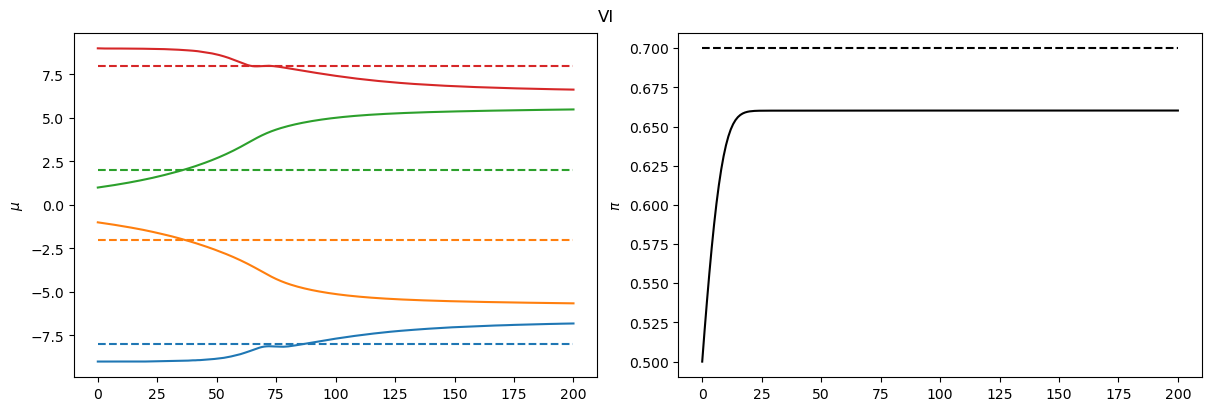

In [14]:
## plot the parameter convergence curve

fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
for j in range(4):
    axs[0].plot(range(n_epochs + 1), record_mu[j], c=f'C{j}', label=f'$\\mu_{j+1}$')
    axs[0].plot([0, n_epochs], [mu_list[j], mu_list[j]], c=f'C{j}', linestyle='--')
axs[0].set_ylabel('$\mu$')

axs[1].plot(range(n_epochs + 1), record_pi, 'k', label="$\\pi$")
axs[1].plot([0, n_epochs], [0.7, 0.7], 'k--')
axs[1].set_ylabel('$\pi$')

fig.suptitle(method)